# Validação comparativa e por simulação dinâmica da *short period approximation*

### Steady-State Flight
$\dot{P}$, $\dot{Q}$, $\dot{R}$ e $\dot{U}$, $\dot{V}$, $\dot{W}$ (ou $\dot{V_{T}}$, $\dot{\beta}$, $\dot{\alpha}$) $\equiv 0$, controles fixos.
Para o caso do STEADY WINGS-LEVEL-FLIGHT:
$\phi$, $\dot{\phi}$, $\dot{\theta}$, $\dot{\psi}$ $\equiv 0$, _i.e._ ($P$, $Q$, $R$ $\equiv 0$)


In [91]:
from pathlib             import Path
import control           as ctrl
import matplotlib.pyplot as plt
import numpy             as np
from scipy import signal
from scipy import linalg
from aerospace_ctrl_toolkit import (
    jsbsim_utils as jsbu,
    presets,
    trim,
    linearize as lin,
)

# Select aircraft
fdm = jsbu.load_aircraft(
    aircraft_model='f104',
    aircraft_path=(Path('.')/'..').resolve(),
)

presets.set_location0_formosa(fdm)

op_cruise = trim.trim_wings_level_flight(
    fdm = fdm,
    ic_h_sl_ft = 5000,
    ic_mach = 0.5,
    fuel_content_lbs = 1000,
)

op_selected = op_cruise



### Linearization 
Desacoplamento Linear das equações de estado para o caso longitudinal tem-se os seguintes vetores de estado (x) e controle (u).

x = [$\alpha$ q $v_{t}$ $\theta$]$^T$
u = [$\delta_{e}$ $\delta_{t}$]$^T$

$E\dot{x}=Ax+Bu$

### Steady-State Conditions for Linearization
$\beta$, $\phi$, $P$, $Q$, $R$ $\equiv 0$
All derivative $\equiv 0$
$V_{T}=V_{T_{e}}$, $\alpha=\alpha_{e}$, $\theta=\theta_{e}$, $\psi\equiv 0$, $\gamma_{e}\equiv 0$,


### Lateral and Dutch_roll Approximation


Dutch Roll Trans Function Poles:
[-1.005+2.92041367j -1.005-2.92041367j]
Dutch Roll Trans Function natural frequency:
3.0885014165449243
Lateral Directional Trans Function Poles:
[-0.93816739+3.27312523j -0.93816739-3.27312523j -0.95215735+0.j
 -0.03850787+0.j          0.        +0.j        ]
Lateral Directional Trans Function natural frequency:
3.404923910346673


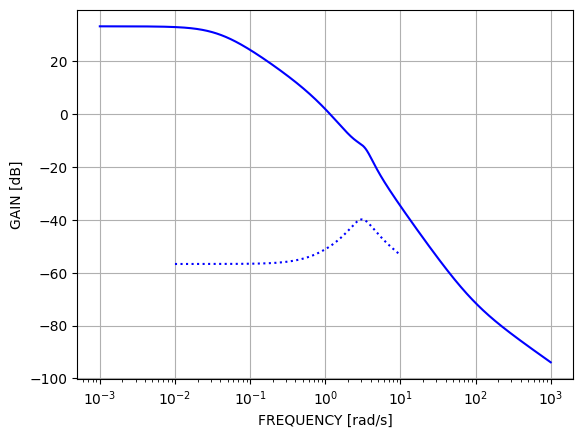

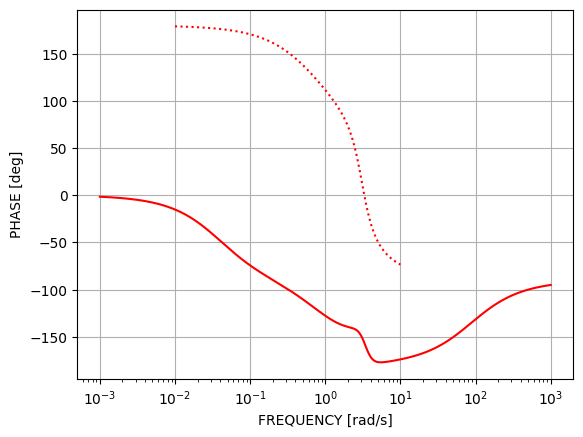

In [92]:
#%% Short-Period Approximation
# Get linear model for each static margin value and flight condition
# ao inves de chamar esse cara, chamar o outro cara
(A, B, states, inputs) = lin.dutch_roll_approximation(
        fdm=fdm,
        operating_point=op_cruise,
    )

# X = [alpha q]^T
# U = [ELEV]
num_outputs = A.shape[0]
C = [1, 1]
D = [0, 0]

sys = signal.StateSpace(A, B, C, D)

print("Dutch Roll Trans Function Poles:")
print(sys.poles)
print("Dutch Roll Trans Function natural frequency:")
print(linalg.norm(sys.poles[0]))

w1, mag1, phase1 = signal.bode(sys, n=1000)

(A,B,states,inputs) = lin.linearize_lateral_directional(
    fdm = fdm,
    operating_point = op_selected,
)

C = [0, 0, 1, 1, 0]
D = [[0, 0]]

sys = signal.StateSpace(A, B, C, D)

print("Lateral Directional Trans Function Poles:")
print(sys.poles)
print("Lateral Directional Trans Function natural frequency:")
print(linalg.norm(sys.poles[0]))

w, mag, phase = signal.bode(sys, n=1000)

plt.figure(0)
plt.semilogx(w1, mag1,':b')    # Bode magnitude plot
plt.semilogx(w, mag,'b')    # Bode magnitude plot
plt.ylabel("GAIN [dB]")
plt.xlabel("FREQUENCY [rad/s]")
plt.grid()

plt.figure(1)
plt.semilogx(w1, phase1,':r')  # Bode phase plot
plt.semilogx(w, phase,'r')  # Bode phase plot
plt.xlabel("FREQUENCY [rad/s]")
plt.ylabel("PHASE [deg]")
plt.grid()

plt.show()
